<a href="https://colab.research.google.com/github/CarlosSMWolff/ParamEst-NN/blob/main/2-Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training of Neural Networks

##  Goal

In this notebook, we train neural networks (NNs) on simulated photon-counting data for the task of parameter estimation.

This notebook will populate the `data\models` folder.


Each row in the training data $x$ consists on lists of time delays between photo-detection events of the form $D=[\tau_1,\ldots,\tau_N]$.

The target data $y$ consist of the true values of the parameters to be estimated (i.e., the parameters used to simulate the photon-counting data).

This corresponds to $\Delta$ in the 1D parameter estimation case, or a vector with the values $[\Delta,\Omega]$ in the 2D parameter estimation case.

## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import *
import os

from tqdm import tqdm

# Find out if this notebook is running in Google Colab
isColab= 'google.colab' in str(get_ipython())
if isColab:
  from google.colab import files
import gc

# We fix the random seed to ensure reproducibility

my_seed_number = 42
# Set the random seed for TensorFlow
tf.random.set_seed(my_seed_number)

# Set the random seed for NumPy (used by TensorFlow for certain operations)
np.random.seed(my_seed_number)

## Setup and requirements

This notebook requires to be run in a folder containing a populated folder `[datapath]\training-trajectories`.

To populate this folder, run the notebook `1-Trajectories_generation.ipynb` in this repository, or download the datasets from [Zenodo](https://zenodo.org/).

### Data path

In [2]:
# specify the data path
datapath = 'data/'

Create data folder in the datapath if not already present

In [3]:
filepath = datapath

import os

if not os.path.exists(filepath):
    os.makedirs(filepath)

### Colab setup

If this notebook is run online in Google Colab, we:
- Download the repository from GitHub to have access to our custom functions in the `src` folder.
- Download a populated `training-trajectories` zipped folder from the link given in the variable `data_folder_address`.

You can change the `data_folder_address` string by any URL pointing to your own data, hosted e.g. in Dropbox (recommended for better download speeds).

In [4]:
# OPTION #1
# ===========
data_folder_link_address = 'https://www.dropbox.com/scl/fi/xqsofxal5zyoxojudexmi/training-trajectories.zip?rlkey=zbgkc2jd83bwdtl5kj7rli22e&dl=0'

# OPTION #2 (Slower, link guaranteed)
# ===========
#data_folder_link_address = 'zenodo link'

In [5]:
if isColab:
  print('We are running in Colab. Downloading repository and data.')
  # Download the repository (necessary to access functions in /src folder)
  ! git clone https://github.com/CarlosSMWolff/ParamEst-NN

  print('Repository downloaded.')
  ! mv ParamEst-NN/* . && rm -r ParamEst-NN

  print('Downloading training-trajectories folder.')
  # Set URL for data
  ! wget -q -O training-trajectories.zip --show-progress "$data_folder_link_address" && unzip -q training-trajectories.zip -d data &&  rm training-trajectories.zip


We are running in Colab. Downloading repository and data.
Cloning into 'ParamEst-NN'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 121 (delta 55), reused 95 (delta 37), pack-reused 0
Receiving objects: 100% (121/121), 1.62 MiB | 13.47 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Repository downloaded.
training-trajectori 100%[===================>]   2.76G  19.4MB/s    in 2m 15s  


### Training strategy

We check if there is a TPU available (running in Colab) and set the corresponding strategy to run on TPU. Otherwise, we use the default distribution strategy based on your hardware and environment.

In [6]:
if 'COLAB_TPU_ADDR' in os.environ:
    print("Tensorflow running in TPU")
elif tf.config.experimental.list_physical_devices('GPU'):
    print("Tensorflow running in GPU")
else:
    print("Tensorflow running in CPU")

def setup_strategy():
    if 'COLAB_TPU_ADDR' in os.environ:
        # TPU setup
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print("Running on TPU")
        strategy = tf.distribute.TPUStrategy(resolver)
    else:
        strategy = tf.distribute.get_strategy()  # Get the default strategy
    return strategy

Tensorflow running in GPU


## Training 1D Models <a id='1D'> </a>

### Load training data (1D $\Delta$ estimation) <a id='load'></a>

In [7]:
path_tau= datapath + "training-trajectories/1D-delta/taus-Delta-1D.npy"
path_param= datapath +"training-trajectories/1D-delta/delta_rand_list-Delta-1D.npy"

In [8]:
tau_list = np.load(path_tau)
Delta_list = np.load(path_param)

ntraj = len(tau_list)

if len(tau_list)!=len(Delta_list):
  print("ERROR: Dimensions of X (tau_list) and Y (Delta_list) do not match!")
else:
  print(f"{ntraj} trajectories loaded")

4000000 trajectories loaded


Select the number of trajectories that we want to use for the training (equal or smaller to number of trajectories loaded)

In [16]:
ntraj_select = 4000

tau_list = tau_list[:ntraj_select].astype(np.float32)
Delta_list = Delta_list[:ntraj_select].astype(np.float32)

- We split the data set: 80% training, 20% validation.

- We do not shuffle the data since the trajectories were already generated randomly

In [17]:
njumps = tau_list.shape[1]

# Set data generated from Monte Carlo
X_train_full, y_train_full = tau_list, Delta_list

lenTrain=int(0.8*len(X_train_full))
X_train, X_valid = X_train_full[:lenTrain], X_train_full[lenTrain:]
y_train, y_valid = y_train_full[:lenTrain], y_train_full[lenTrain:]

### Model #1: RNN architecture
<a id='RNN'></a>

Define and train the network

In [18]:
def create_model():
  # Set the RNN
  dropout = 0.
  activation = "relu"
  modelRNN = keras.models.Sequential(
  [keras.layers.LSTM(17,input_shape=[None,1],return_sequences=True, activation=activation,dropout=dropout),
  keras.layers.LSTM(17, return_sequences=False, activation=activation,dropout=dropout),
  keras.layers.Dense(1)]
  )
  return modelRNN

Training details

In [25]:
epochs = 150
batch_size = 12800
optimizer = "adam"
loss =  tf.keras.losses.MeanSquaredLogarithmicError()
metrics = ["MeanSquaredError"]

Perform training
- If the notebook is run in Colab, it tries to use TPU.
- Otherwise, train in local machine.

In [26]:
tf.keras.backend.clear_session()
strategy = setup_strategy()

with strategy.scope():
  modelRNN = create_model()
  modelRNN.compile(
      optimizer= optimizer,
      loss=loss,
            metrics=[metrics]
      )

  historyRNN=modelRNN.fit(np.expand_dims(X_train,axis=-1), y_train,
      epochs=epochs,
      batch_size = batch_size,
      validation_data=(np.expand_dims(X_valid,axis=-1), y_valid),
      validation_freq=1
)

Epoch 1/150
1/1 [==============================] - 4s 4s/step - loss: 1.0354 - mean_squared_error: 226.3897 - val_loss: 0.7845 - val_mean_squared_error: 93.8546
Epoch 2/150
1/1 [==============================] - 1s 504ms/step - loss: 0.8243 - mean_squared_error: 121.4483 - val_loss: 0.6373 - val_mean_squared_error: 44.4986
Epoch 3/150
1/1 [==============================] - 1s 586ms/step - loss: 0.6680 - mean_squared_error: 57.2979 - val_loss: 0.5436 - val_mean_squared_error: 20.5185
Epoch 4/150
1/1 [==============================] - 0s 316ms/step - loss: 0.5631 - mean_squared_error: 26.4268 - val_loss: 0.4841 - val_mean_squared_error: 10.0073
Epoch 5/150
1/1 [==============================] - 0s 274ms/step - loss: 0.4937 - mean_squared_error: 12.4141 - val_loss: 0.4417 - val_mean_squared_error: 5.9410
Epoch 6/150
1/1 [==============================] - 0s 240ms/step - loss: 0.4439 - mean_squared_error: 6.8602 - val_loss: 0.4038 - val_mean_squared_error: 4.6407
Epoch 7/150
1/1 [=========

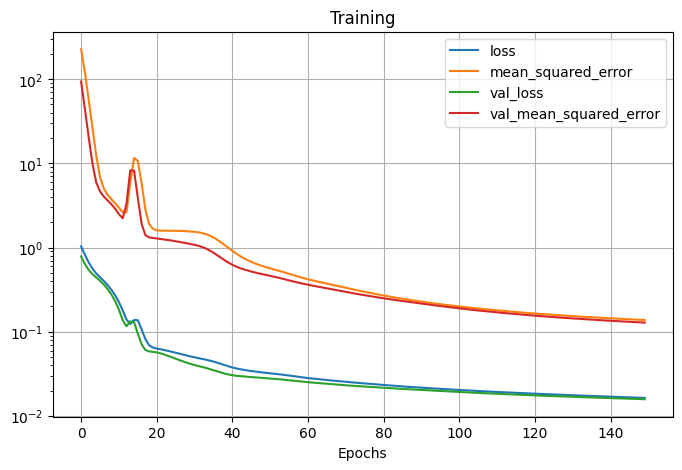

In [27]:
pd.DataFrame(historyRNN.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.title("Training")
plt.grid(True)
plt.yscale("log")
plt.show()


Visualize the predictions made by the model in the validation set

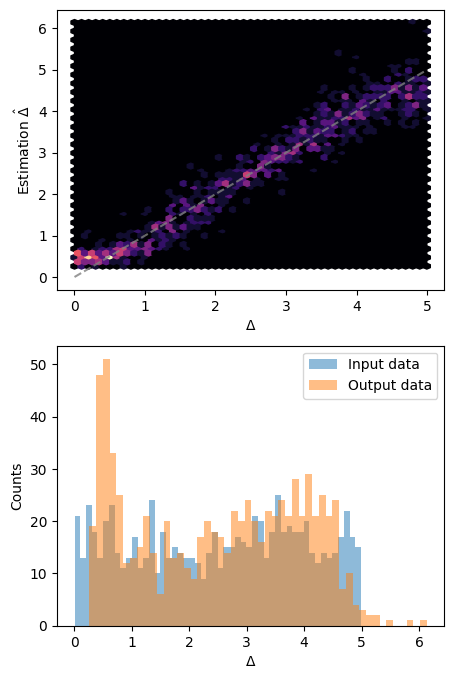

In [28]:
nsel = 1000
x_values = X_valid[np.argsort(y_valid[:nsel])]
output = modelRNN(x_values)[:,0]

input = np.sort(y_valid[:nsel])

fig, axes = plt.subplots(nrows = 2, figsize = (5,8))
ax = axes[0]
ax.hexbin(input,output, gridsize=50, cmap = 'magma')
ax.plot(input,input,'--',color="gray",alpha=0.8)
ax.set_xlabel("$\Delta$"); ax.set_ylabel("Estimation $\hat \Delta$")

ax = axes[1]
ax.hist(input,bins = 50, alpha = 0.5, label = "Input data")
ax.hist(output,bins = 50, alpha = 0.5, label = "Output data")
ax.set_xlabel("$\Delta$"); ax.set_ylabel("Counts")
ax.legend()
plt.show()

Save the model

In [30]:
modelTrainName = f'model-RNN.h5'

save_dir = datapath+"models/1D/"
save_path = save_dir + modelTrainName
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

modelRNN.save(save_path)

if isColab:
    from google.colab import files
    files.download(save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model #2: Hist-Dense architecture
<a id='Hist'></a>

Define the model


In [31]:
from src.custom_layers import MyHistogramLayer_Sigmoid

nbins = 700
taumax = 100
width = taumax/nbins


def create_model_Hist():
  # Set the model
  activation = "relu"
  droprate = 0.
  modelHist = keras.models.Sequential(
  [
  MyHistogramLayer_Sigmoid(nbins, taumax, trainable = False),
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

Setup the training

In [32]:
  epochs = 100
  batch_size = 12800
  optimizer = "adam"
  loss = tf.keras.losses.MeanSquaredLogarithmicError()
  metrics = ["MeanSquaredError"]

Training

In [34]:
tf.keras.backend.clear_session()
strategy = setup_strategy()

with strategy.scope():
  modelHist = create_model_Hist()
  modelHist.compile(
      optimizer= optimizer,
      loss=loss,
            metrics=[metrics]
      )

history=modelHist.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(X_valid, y_valid),
    validation_freq=1)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.1891 - mean_squared_error: 7.3598 - val_loss: 0.9487 - val_mean_squared_error: 6.7920
Epoch 2/100
1/1 [==============================] - 0s 61ms/step - loss: 0.9066 - mean_squared_error: 6.4451 - val_loss: 0.7461 - val_mean_squared_error: 5.9898
Epoch 3/100
1/1 [==============================] - 0s 61ms/step - loss: 0.7089 - mean_squared_error: 5.6620 - val_loss: 0.5902 - val_mean_squared_error: 5.2316
Epoch 4/100
1/1 [==============================] - 0s 66ms/step - loss: 0.5569 - mean_squared_error: 4.9242 - val_loss: 0.4634 - val_mean_squared_error: 4.4783
Epoch 5/100
1/1 [==============================] - 0s 57ms/step - loss: 0.4337 - mean_squared_error: 4.1942 - val_loss: 0.3633 - val_mean_squared_error: 3.7467
Epoch 6/100
1/1 [==============================] - 0s 60ms/step - loss: 0.3367 - mean_squared_error: 3.4879 - val_loss: 0.2889 - val_mean_squared_error: 3.0688
Epoch 7/100
1/1 [=========================

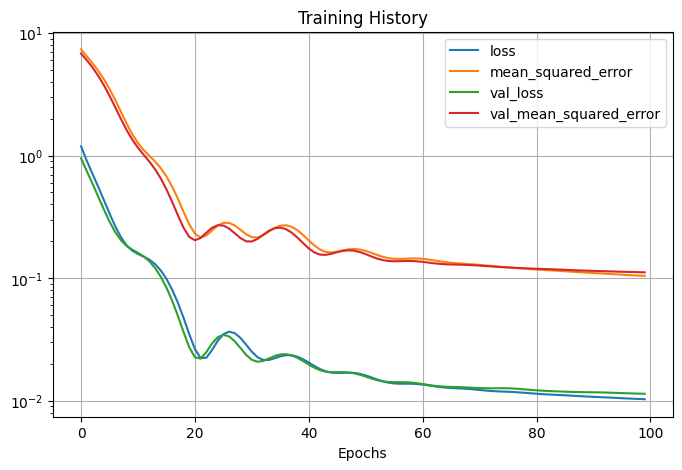

In [35]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.title("Training History")
plt.grid(True)
#plt.gca().set_ylim(0, 50) # set the vertical range to [0-1]
plt.yscale("log")
#plt.ylim(0.1,0.2)
plt.show()

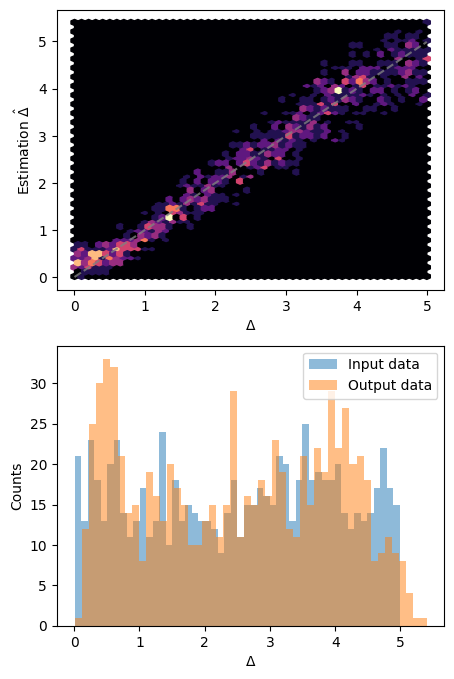

In [36]:
nsel = 1000
x_values = X_valid[np.argsort(y_valid[:nsel])]
output = modelHist.predict(x_values, verbose=False)[:,0]

input = np.sort(y_valid[:nsel])

fig, axes = plt.subplots(nrows = 2, figsize = (5,8))
ax = axes[0]
ax.hexbin(input,output, gridsize=50, cmap = 'magma')
ax.plot(input,input,'--',color="gray",alpha=0.8)
ax.set_xlabel("$\Delta$"); ax.set_ylabel("Estimation $\hat \Delta$")

ax = axes[1]
ax.hist(input,bins = 50, alpha = 0.5, label = "Input data")
ax.hist(output,bins = 50, alpha = 0.5, label = "Output data")
ax.set_xlabel("$\Delta$"); ax.set_ylabel("Counts")
ax.legend()
plt.show()

Save the model

In [37]:
modelTrainName = f'model-Hist.h5'

save_dir = datapath+"models/1D/"
save_path = save_dir + modelTrainName
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

modelRNN.save(save_path)

if isColab:
    from google.colab import files
    files.download(save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Training Hist-Dense models with noise in the y_train

Define the model

In [38]:
from src.custom_layers import MyHistogramLayer_Sigmoid

nbins = 700
taumax = 100
width = taumax/nbins


def create_model_Hist():
  # Set the model
  activation = "relu"
  droprate = 0.
  modelHist = keras.models.Sequential(
  [
  MyHistogramLayer_Sigmoid(nbins, taumax, trainable = False),
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

Define $\sigma$ interval

In [39]:
sigma_min = 0.;sigma_max = 1.;nsigma = 30; sigma_list = np.linspace(sigma_min,sigma_max,nsigma)

Setup the training

In [40]:
  epochs = 20
  optimizer = "adam"
  loss = tf.keras.losses.MeanSquaredLogarithmicError()
  metrics = ["MeanSquaredError"]

Create callback to save the model of the best epoch during training

In [41]:
file_dir = datapath+"models/1D/noise-y-train/"

if not os.path.exists(file_dir):
  os.makedirs(file_dir)

def Create_Callback(sigma):
  filepath= file_dir+ 'model_best_Hist-sigma_'+str(sigma)+'.hdf5'

  checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=True,
                              mode='min')

  callbacks = [checkpoint]
  return callbacks

Loop over $\sigma$

In [42]:
! rm -r "$datapath"models/1D/noise-y-train/*

tf.keras.backend.clear_session()
strategy = setup_strategy()

with strategy.scope():
  modelHist = create_model_Hist()
  modelHist.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

with strategy.scope():
  model_Prev = tf.keras.models.clone_model(modelHist)
  model_Prev.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

# First do a very quick training to initialize the weights for later training
sigma = 0.
noise = np.random.normal(loc=0., scale=sigma, size=len(y_train))
y_train_noise = np.abs(y_train + noise)
noise_valid = np.random.normal(loc=0., scale=sigma, size=len(y_valid))
y_valid_noise = np.abs(y_valid + noise_valid)

model_Prev.fit(X_train.astype(np.float32),
                      y_train_noise.astype(np.float32),
                      epochs=2,
                      callbacks=Create_Callback(sigma),
                        batch_size = 1280, validation_data=(X_valid.astype(np.float32), y_valid_noise.astype(np.float32)), validation_freq=1,
                        verbose = False)

# Now loop over sigma
history_list = []
for sigma in tqdm(sigma_list):

    # First we create a model cloning the partially trained one
    with strategy.scope():
      model = tf.keras.models.clone_model(model_Prev)
      model.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

      # Add noise to data
      noise = np.random.normal(loc=0., scale=sigma, size=len(y_train))
      y_train_noise = np.abs(y_train + noise)
      noise_valid = np.random.normal(loc=0., scale=sigma, size=len(y_valid))
      y_valid_noise = np.abs(y_valid + noise_valid)

      # Fit the model with noisy data
      history = model.fit(X_train.astype(np.float32),
                      y_train_noise.astype(np.float32),
                      epochs=epochs,
                      callbacks=Create_Callback(sigma),
                        batch_size = 1280, validation_data=(X_valid.astype(np.float32), y_valid_noise.astype(np.float32)), validation_freq=1,
                        verbose = False)

      # Store the history of the training
      history_list.append(history)

rm: cannot remove 'data/models/1D/noise-y-train/*': No such file or directory


100%|██████████| 30/30 [02:26<00:00,  4.90s/it]


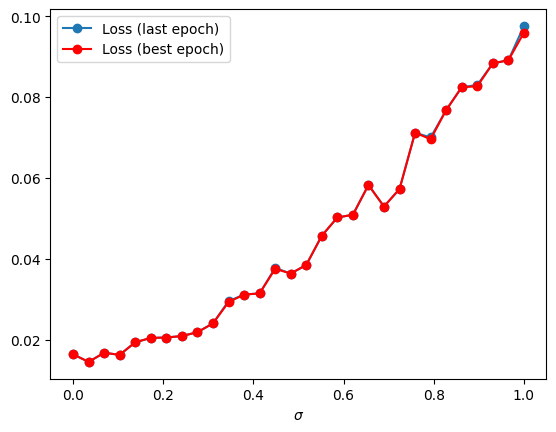

In [43]:
histories = [pd.DataFrame(result.history) for result in history_list]
val_loss_list = np.array([history.val_loss for history in histories])

plt.plot(sigma_list,val_loss_list[:,-1],'-o', label = "Loss (last epoch)")
plt.plot(sigma_list,np.min(val_loss_list,axis=1),'-ro', label = "Loss (best epoch)")
plt.legend()
plt.xlabel("$\sigma$"); plt.ylabel("")
plt.show()

If we are in Colab, we zip and download the files

In [44]:
if isColab:
  !zip -r models-sigma-y-train.zip "$datapath"models/1D/noise-y-train/
  files.download("models-sigma-y-train.zip")

  adding: data/models/1D/noise-y-train/ (stored 0%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.48275862068965514.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.9310344827586207.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.20689655172413793.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_1.0.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.8620689655172413.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.8275862068965517.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.6551724137931034.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.7931034482758621.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.10344827586206896.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Training Hist models with noise in the x_train

Define the model

In [46]:
from src.custom_layers import MyHistogramLayer_Sigmoid

nbins = 700
taumax = 100
width = taumax/nbins


def create_model_Hist():
  # Set the model
  activation = "relu"
  droprate = 0.
  modelHist = keras.models.Sequential(
  [
  MyHistogramLayer_Sigmoid(nbins, taumax, trainable = False),
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

Define $\sigma$ interval

In [47]:
sigma_min = 0.;sigma_max = 1.;nsigma = 30; sigma_list = np.linspace(0,sigma_max,nsigma)

Setup the training

In [48]:
epochs = 10
batch_size = 1280
#optimizer = tf.keras.optimizers.legacy.Adam(  learning_rate=0.0001)
optimizer = "adam"
loss = tf.keras.losses.MeanSquaredLogarithmicError()
metrics = ["MeanSquaredError"]

Define Callback to save the model of the best epoch during training

In [49]:
file_dir = datapath+"models/1D/noise-x-train/"

if not os.path.exists(file_dir):
  os.makedirs(file_dir)

def Create_Callback(sigma):
  filepath= file_dir+ 'model_best_Hist-sigma_'+str(sigma)+'.hdf5'

  checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=True,
                              mode='min')

  callbacks = [checkpoint]
  return callbacks

Loop over $\sigma$

In [50]:
# Clean the "data/models/noise-x-train" folder
! rm -r "$datapath"models/1D/noise-x-train


tf.keras.backend.clear_session()
strategy = setup_strategy()

with strategy.scope():
  modelHist = create_model_Hist()
  modelHist.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

with strategy.scope():
  model_Prev = tf.keras.models.clone_model(modelHist)
  model_Prev.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

# First do a very quick training to initialize the weights for later training
sigma = 0.
model_Prev.fit(X_train.astype(np.float32),
                      y_train.astype(np.float32),
                      epochs=2,
                      callbacks=Create_Callback(sigma),
                        batch_size = batch_size, validation_data=(X_valid.astype(np.float32), y_valid.astype(np.float32)), validation_freq=1,
                        verbose = False)

# Now loop over sigma
history_list = []
for sigma in tqdm(sigma_list):

  # First we create a model cloning the partially trained one
  with strategy.scope():
    model = tf.keras.models.clone_model(model_Prev)
    model.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

  # Add noise to x- data (delays)
  noise = np.random.normal(loc=0., scale=sigma, size=tau_list.shape)
  tau_list_noise = (tau_list + noise).clip(min=0.001)
  #Proper shape to x-data
  X_train_full_Hist = tau_list_noise
  lenTrain=int(0.8*len(X_train_full))
  X_train_Hist, X_valid_Hist = X_train_full_Hist[:lenTrain], X_train_full_Hist[lenTrain:]

  # Fit the model with noisy data
  history = model.fit(X_train_Hist.astype(np.float32),
                  y_train.astype(np.float32),
                  epochs=epochs,
                  callbacks=Create_Callback(sigma),
                    batch_size = batch_size, validation_data=(X_valid_Hist.astype(np.float32), y_valid.astype(np.float32)), validation_freq=1,
                    verbose = False)

    # Store the history of the training
  history_list.append(history)

100%|██████████| 30/30 [01:47<00:00,  3.59s/it]


In [51]:
histories = [pd.DataFrame(result.history) for result in history_list]
val_loss_list = np.array([history.val_loss for history in histories])

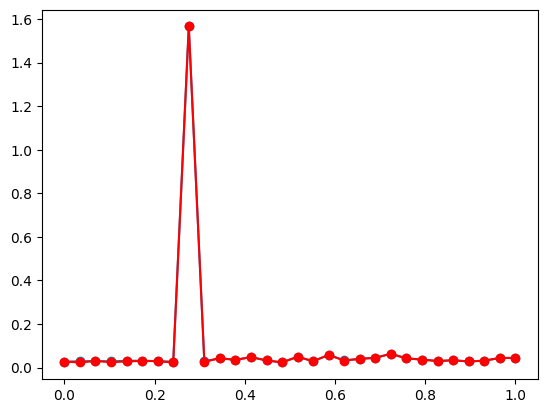

In [52]:
plt.plot(sigma_list,val_loss_list[:,-1],'-o')
plt.plot(sigma_list,np.min(val_loss_list,axis=1),'-ro')
#plt.yscale('log')
#plt.xscale('log')
plt.show()

In [53]:
!zip -r models-sigma-x-train.zip "$datapath"models/1D/noise-x-train/

from google.colab import files
files.download("models-sigma-x-train.zip")

  adding: data/models/1D/noise-x-train/ (stored 0%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.48275862068965514.hdf5 (deflated 12%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.9310344827586207.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.20689655172413793.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_1.0.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.8620689655172413.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.8275862068965517.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.6551724137931034.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.7931034482758621.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.10344827586206896.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training 2D Models <a id='1D'> </a>

### Load data <a id='load'></a>

#### Training data: 2D  estimation [$\Delta$,$\Omega$]

- If this notebook is run online in Google Colab, we download the data from the online repo and the necessary src files.
- Otherwise, we accesss to the local data in `data/training`

In [56]:
path_tau= datapath+"training-trajectories/2D-delta-omega/taus-2D.npy"
path_param= datapath+"/training-trajectories/2D-delta-omega/param_rand_list-2D.npy"

In [57]:
tau_list = np.load(path_tau)
param_list = np.load(path_param)

Select number of trajectories that we will use for the training

In [59]:
ntraj_select = 4000
tau_list = tau_list[:ntraj_select].astype(np.float32)
param_list = param_list[:ntraj_select].astype(np.float32)

- We split the data set: 80% training, 20% validation.

- We do not shuffle the data since the trajectories were already generated randomly

In [60]:
njumps = tau_list.shape[1]

# Set data generated from Monte Carlo
X_train_full, y_train_full = tau_list, param_list

lenTrain=int(0.8*len(X_train_full))
X_train, X_valid = X_train_full[:lenTrain], X_train_full[lenTrain:]
y_train, y_valid = y_train_full[:lenTrain], y_train_full[lenTrain:]

### Model: Hist-Dense Architecture

In [61]:
from src.custom_layers import MyHistogramLayer_Sigmoid

Define the model

In [62]:
# Custom-made histogram function
nbins = 700
taumax = 100
width = taumax/nbins

def create_model_Hist2D():
  # Set the model
  activation = "relu"
  droprate = 0
  modelHist = keras.models.Sequential(
  [
  MyHistogramLayer_Sigmoid(nbins, taumax, trainable = False),
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
   keras.layers.Dense(20, activation=activation),
   keras.layers.Dropout(droprate),
   keras.layers.Dense(10, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(2)
   ]
  )
  return modelHist

Setup training

In [63]:
epochs = 1200
epochs = 50
batch_size = 12800
optimizer = "adam"
loss = tf.keras.losses.MeanSquaredLogarithmicError()
metrics = ["MeanSquaredError"]

Train

In [64]:
tf.keras.backend.clear_session()
strategy = setup_strategy()

with strategy.scope():
  modelHist = create_model_Hist2D()
  modelHist.compile(
      optimizer= optimizer,
      loss=loss,
            metrics=[metrics]
      )

history=modelHist.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(X_valid, y_valid))


Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 1.2300 - mean_squared_error: 6.4823 - val_loss: 1.1954 - val_mean_squared_error: 6.1721
Epoch 2/50
1/1 [==============================] - 0s 73ms/step - loss: 1.1690 - mean_squared_error: 5.8652 - val_loss: 1.0663 - val_mean_squared_error: 5.6909
Epoch 3/50
1/1 [==============================] - 0s 63ms/step - loss: 1.0351 - mean_squared_error: 5.3830 - val_loss: 0.9426 - val_mean_squared_error: 5.3587
Epoch 4/50
1/1 [==============================] - 0s 65ms/step - loss: 0.9103 - mean_squared_error: 5.0462 - val_loss: 0.8523 - val_mean_squared_error: 5.1087
Epoch 5/50
1/1 [==============================] - 0s 74ms/step - loss: 0.8185 - mean_squared_error: 4.7923 - val_loss: 0.7672 - val_mean_squared_error: 4.8521
Epoch 6/50
1/1 [==============================] - 0s 68ms/step - loss: 0.7346 - mean_squared_error: 4.5398 - val_loss: 0.6835 - val_mean_squared_error: 4.5762
Epoch 7/50
1/1 [==============================] 

In [65]:
modelTrainName = f'model-Hist-Dense-2D.h5'


save_dir = datapath+"models/2D/"
save_path = save_dir + modelTrainName
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

modelRNN.save(save_path)

if isColab:
    from google.colab import files
    files.download(save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>